**tradSIMO**<br>
by $\text{Rishabh Pomaje}$

- This file contains the code that simulates a $1 \times 2$ system and peforms ***M**aximal **R**atio **C**oding* (MRC)
- The results are meant to be used as benchmarks for the DNN learnt in the file $\color{tan}{deepSIMO.ipynb}$
- Two streams are considered as follows :
    1. Without any channel coding
    2. With Hamming (7, 4) channel code<br>
    a. Hard decision + Syndrom-based decoding<br>
    b. 

In [1]:
# Dependencies :
import numpy as np 
import matplotlib.pyplot as plt 
%config InlineBackend.figure_format='svg'

- Function Defintions

In [2]:
# Importing from custom made module : CommSysLib.py
import CommSysLib as csl 

- Some definitions :
\begin{equation}
    \text{SNR}_{linear} = \text{Signal-to-noise power ratio per symbol time} = \frac{E_b}{N_0}
\end{equation}
Consider,
\begin{equation*}
    \frac{1}{2 \times SNR_{linear}} = \frac{1 \times N_0}{2 \times E_b} = \frac{N_0}{2} \;\dots (E_b = 1) 
\end{equation*}

\begin{equation*}
    \frac{1}{2 \times R \times SNR_{linear}} = \frac{1 \times n \times N_0}{2 \times k \times E_b} = n/k \times N_0/2 \;\dots (E_b = 1)
\end{equation*}

In [3]:
k, n = 4, 7     # Uncoded and Coded block lengths  
R = k / n       # Information rate
E_b = 1         # Energy per bit

# SNR range in dB and linear scale 
n_points = 30 
SNR_dB = np.linspace(-2, 20, n_points)
SNR_lin = 10 ** (SNR_dB / 10)

# Variance of only the real(imag) component of the noise 
noise_var_uncoded = 1 / (2 * SNR_lin)
noise_var_coded = 1 / (2 * R * SNR_lin)
# Fading model parameters :: Rayleigh fading 
fade_mean = 0 
fade_std = np.sqrt(0.5) 

- Data Generation (Random Binary Data) 

In [4]:
n_bits = 10 ** 7
n_bits_c = n_bits * n // k
binary_stream_tx = np.random.randint(0, 2, n_bits)

print(f'Samples : {binary_stream_tx[:10]}')

Samples : [1 1 1 1 0 1 0 0 0 1]


### Without channel coding

- Constellation mapping

In [5]:
signal_stream_tx = csl.BPSK_mapper(binary_stream_tx, 1)

print(f'Samples : {signal_stream_tx}')

Samples : [-1. -1. -1. ... -1.  1.  1.]


- Simulating the channel and the decoding 

In [6]:
BLER_uncoded_mrc = []
count = 0
for noise in noise_var_uncoded:
    # Fading
    fade_taps_01 = np.random.normal(fade_mean, fade_std, n_bits) + 1j * np.random.normal(fade_mean, fade_std, n_bits)
    fade_taps_02 = np.random.normal(fade_mean, fade_std, n_bits) + 1j * np.random.normal(fade_mean, fade_std, n_bits)
    signal_stream_rx_01 = fade_taps_01 * signal_stream_tx
    signal_stream_rx_02 = fade_taps_02 * signal_stream_tx 
    # Noise 
    noise_samples_01 = np.random.normal(0, np.sqrt(noise), n_bits) + 1j * np.random.normal(0, np.sqrt(noise), n_bits)
    noise_samples_02 = np.random.normal(0, np.sqrt(noise), n_bits) + 1j * np.random.normal(0, np.sqrt(noise), n_bits)
    signal_stream_rx_01 = signal_stream_rx_01 + noise_samples_01
    signal_stream_rx_02 = signal_stream_rx_02 + noise_samples_02
    # Decoding
    binary_stream_rx = csl.mrc_decoding([signal_stream_rx_01, signal_stream_rx_02], [fade_taps_01, fade_taps_02])
    # Analysis 
    _, BLER = csl.calcBLER(binary_stream_tx, binary_stream_rx, k)
    BLER_uncoded_mrc.append(BLER)
    # Progress Update 
    count += 1
    print(f'Progress : {100 * count // n_points} %', end='\r')

### With Channel Coding

- Channel Coding

In [7]:
# Matrices for Hamming (7, 4) code:
# Generator :
G = np.array([
    [1, 0, 0, 0, 1, 1, 0],
    [0, 1, 0, 0, 1, 0, 1],
    [0, 0, 1, 0, 0, 1, 1],
    [0, 0, 0, 1, 1, 1, 1]
], dtype=int)

# Parity Check 
H = np.array([
    [1, 1, 0, 1, 1, 0, 0],
    [1, 0, 1, 1, 0, 1, 0],
    [0, 1, 1, 1, 0, 0, 1]
], dtype=int)

channel_coded_stream_tx = csl.hamming_encoder(binary_stream_tx, G)

print(f'Samples = {channel_coded_stream_tx[:10]}')
print(f'Length = {len(channel_coded_stream_tx)}')

Samples = [1 1 1 1 1 1 1 0 1 0]
Length = 17500000


- Constellation mapping

In [8]:
signal_stream_tx = csl.BPSK_mapper(channel_coded_stream_tx, E_b)

print(f'Samples = {signal_stream_tx}')

Samples = [-1. -1. -1. ...  1. -1. -1.]


- Simulating the channel and the decoding

1.  Hard decision and Syndrome Decoding 

In [9]:
BLER_coded_mrc_hard = []
count = 0 
for noise in noise_var_coded:
    # Fading 
    fade_taps_01 = np.random.normal(fade_mean, fade_std, n_bits_c) + 1j * np.random.normal(fade_mean, fade_std, n_bits_c)
    fade_taps_02 = np.random.normal(fade_mean, fade_std, n_bits_c) + 1j * np.random.normal(fade_mean, fade_std, n_bits_c)
    signal_stream_rx_01 = fade_taps_01 * signal_stream_tx
    signal_stream_rx_02 = fade_taps_02 * signal_stream_tx
    # Noise 
    noise_samples_01 = np.random.normal(0, np.sqrt(noise), n_bits_c) + 1j * np.random.normal(0, np.sqrt(noise), n_bits_c)
    noise_samples_02 = np.random.normal(0, np.sqrt(noise), n_bits_c) + 1j * np.random.normal(0, np.sqrt(noise), n_bits_c)
    signal_stream_rx_01 = signal_stream_rx_01 + noise_samples_01
    signal_stream_rx_02 = signal_stream_rx_02 + noise_samples_02
    # Decoding
    binary_stream_rx = csl.hamming_decoder(csl.mrc_decoding([signal_stream_rx_01, signal_stream_rx_02], [fade_taps_01, fade_taps_02]), H)
    # Analysis
    _, BLER = csl.calcBLER(binary_stream_tx, binary_stream_rx, k)
    BLER_coded_mrc_hard.append(BLER)
    # Progress Update
    count += 1
    print(f'Progress : {100 * count // n_points} %', end='\r')

2. Maximum Likelihood Decoding

In [10]:
BLER_coded_mrc_mld = []
count = 0 
for noise in noise_var_coded:
    # Fading 
    fade_taps_01 = np.random.normal(fade_mean, fade_std, n_bits_c) + 1j * np.random.normal(fade_mean, fade_std, n_bits_c)
    fade_taps_02 = np.random.normal(fade_mean, fade_std, n_bits_c) + 1j * np.random.normal(fade_mean, fade_std, n_bits_c)
    signal_stream_rx_01 = fade_taps_01 * signal_stream_tx
    signal_stream_rx_02 = fade_taps_02 * signal_stream_tx
    # Noise 
    noise_samples_01 = np.random.normal(0, np.sqrt(noise), n_bits_c) + 1j * np.random.normal(0, np.sqrt(noise), n_bits_c)
    noise_samples_02 = np.random.normal(0, np.sqrt(noise), n_bits_c) + 1j * np.random.normal(0, np.sqrt(noise), n_bits_c)
    signal_stream_rx_01 = signal_stream_rx_01 + noise_samples_01
    signal_stream_rx_02 = signal_stream_rx_02 + noise_samples_02
    # Decoding
    binary_stream_rx = csl.mrc_decoding([signal_stream_rx_01, signal_stream_rx_02], [fade_taps_01, fade_taps_02], False)
    binary_stream_rx = csl.ML_Detection(binary_stream_rx, G, E_b, n, k)
    # Analysis
    _, BLER = csl.calcBLER(binary_stream_tx, binary_stream_rx, k)
    BLER_coded_mrc_mld.append(BLER)
    # Progress Update
    count += 1
    print(f'Progress : {100 * count // n_points} %', end='\r')

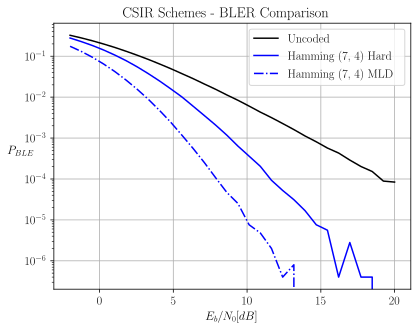

In [13]:
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 12,
    "font.family" : 'Serif'
})
fig, axes = plt.subplots()
axes.semilogy(SNR_dB, BLER_uncoded_mrc, label='Uncoded', color='black')
axes.semilogy(SNR_dB, BLER_coded_mrc_hard, label='Hamming (7, 4) Hard', color='blue')
axes.semilogy(SNR_dB, BLER_coded_mrc_mld, label='Hamming (7, 4) MLD', color='blue', ls='-.')
axes.set_xlabel(r'$E_b / N_0 [dB]$')
axes.set_ylabel(r'$P_{BLE}$', rotation=0)
# axes.set_xlim(-3, 21)
# axes.set_ylim(10**-5,10**0)
axes.legend()
axes.set_title(f'CSIR Schemes - BLER Comparison')
axes.grid(True, which="major")

In [14]:
# Saving the results for future reference :
# Plot(s):
fig.savefig("plots/tradSIMO.svg", transparent=True)
# BLER values :
with open("results/tradSIMO.txt", mode='w') as file_id:
    file_id.write(f'BLER_uncoded_mrc = {BLER_uncoded_mrc}\n')
    file_id.write(f'BLER_coded_mrc_hard = {BLER_coded_mrc_hard}\n')
    file_id.write(f'BLER_coded_mrc_mld = {BLER_coded_mrc_mld}\n')